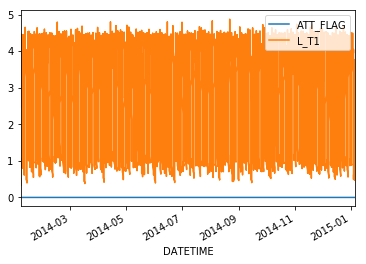

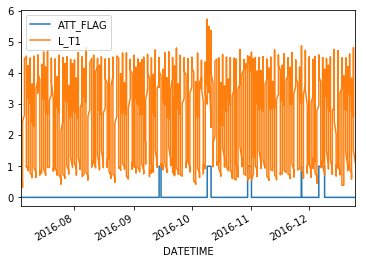

In [337]:
from pandas import read_csv
from pandas import datetime
import pandas
import math
from matplotlib import pyplot
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import robust_scale
import time
from sklearn.decomposition import PCA
import scipy.stats
import matplotlib.pyplot as plt
from  sklearn.metrics import confusion_matrix
from numpy import linalg as LA
import numpy as np
def parse_date(x):    
    date = str(x).split(' ')[0]
    time_stamp = datetime.strptime(date,'%d/%m/%y')
    return time_stamp
df_1 = read_csv('BATADAL_dataset_training_1.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_2 = read_csv('BATADAL_dataset_training_2.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_1['ATT_FLAG'] = -df_1['ATT_FLAG']/1000 + 1/1000
df_2['ATT_FLAG'] = 1-(-df_2['ATT_FLAG']/1000 + 1/1000)
cols = ['ATT_FLAG', 'L_T1']
df_1.plot(x='DATETIME', y= cols)
df_2.plot(x='DATETIME', y= cols)
pyplot.show()

In [338]:
def convert_df(df) :
    labels = df['ATT_FLAG'].values
    x_df = df.drop('ATT_FLAG',1).drop('DATETIME', 1)
    features = x_df.values
    (n,m) = features.shape
    #scaler = MinMaxScaler()
    #scaler.fit(features)
    x = robust_scale(features)
    return (x, labels, n,m)

def scale_min_max(x):
    (n,m) = x.shape
    for j in range(0,m):
        feat = x[:,j]
        xmin = np.min(feat)
        xmax = np.max(feat)
        if(abs(xmin) > abs(xmax) and xmin != 0):
            xmax = -xmin
        if xmax == xmin and xmin == 0:
            x[:,j] = x[:,j] 
        else:
            x[:,j] = (x[:,j])/(xmax)
    return x
(x_1, y_1, n_1, m_1) = convert_df(df_1)
(x_2, y_2, n_2, m_2) = convert_df(df_2)

PCA Task:

In [352]:
#Splits principal axes in normal and anomalous sets
#Outputs index of column which first exceeds the threshold

def seperate_anomalous(x_norm,t,m):
    i = 0
    for i in range(0, m):
        u = x_norm[:,i]
        mu = np.mean(u)
        std = math.sqrt(np.std(u))
        t_min = mu-(std*t)
        t_max = mu+(std*t)
        breach= np.any(u<t_min) or np.any(u>t_max)
        if breach:
            break
    return i

#Calculates the Squared Prediction Error for all residual data
def calc_SPE(x_a,n):
    spes = np.empty([n])
    for i in range(0,n):
        y = x_a[:,i] 
        spes[i] = np.dot(y, y.T)
    return spes

#Calculates the Q-statistic on the residual data
def calc_q_stat(alpha, x, comps,r,m):
    phi_1 = calc_phi(1,m,r,x,comps)
    phi_2 = calc_phi(2,m,r,x,comps)
    phi_3 = calc_phi(3,m,r,x,comps)
    h_0 = 1 - ((2*phi_1*phi_3)/(3*phi_2**2))
    c_a = scipy.stats.norm.ppf(1-alpha)
    
    left_part = c_a * math.sqrt(2*phi_2* h_0**2)/phi_1
    right_part = phi_2* h_0*(h_0-1) /phi_1**2 
    
    center_part = left_part+1+right_part

    d2_a = phi_1 * center_part**(1/h_0)
    return d2_a

#Helper function for calculating the Q-statistic 
def calc_phi(i,m,r,x,comps):  
    res = 0
    for j in range(r+1,m):
        v_j = comps[:,j]
        xv = np.dot(x,v_j)
        l_j = LA.norm(xv)
        res = res + l_j**i
    return res

#Initiates the PCA-based anomality detection on the given dataset 
#Outputs a list of all datapoints deemed as abnomal
def init_pca(n,m,x,y,alpha,t):
    pca = PCA(n_components=m)
    pca.fit(x)
    proj_x = pca.transform(x)
    norm_x = normalize(proj_x, norm='l1', axis=0)
    idx =  seperate_anomalous(norm_x, t,m)  
    r= idx-1
    prin_comps = pca.components_
    P = prin_comps[:,0:r]
    C = np.dot(P, P.T)
    I = np.identity(m)

    x_n = np.dot(C, x.T)
    x_a = np.dot(I-C, x.T)
    spes = calc_SPE(x_a,n)
    q_stat = calc_q_stat(alpha, x_2, prin_comps,r,m)
    abnomal = spes > q_stat
    return abnomal

#Tunes threshold and alpha values on given dataset   
def tune_params(cand_alpha,cand_t,n,m,x,y):
    best_t = 0
    best_a = 0
    fp_v = n*m

    for alpha in cand_alpha:
        for t in cand_t:
            pred_y = init_pca(n, m, x, y, alpha,t)
            #print("Alpha: " +str(alpha))
            #print("threshold: "+ str(t))
            #print(confusion_matrix(y, pred_y))
            tn, fp, fn, tp = confusion_matrix(y, pred_y).ravel()
            if fp < fp_v:
                best_t = t
                best_a = alpha
                fp_v = fp 
    return (best_t, best_a)

[0. 0. 0. ... 0. 0. 0.]
[[3937   21]
 [ 160   59]]
[0. 0. 0. ... 0. 0. 0.]
[[3930   28]
 [ 159   60]]
[0. 0. 0. ... 0. 0. 0.]
[[3930   28]
 [ 159   60]]
[0. 0. 0. ... 0. 0. 0.]
[[3930   28]
 [ 159   60]]
[0. 0. 0. ... 0. 0. 0.]
[[3930   28]
 [ 159   60]]
[0. 0. 0. ... 0. 0. 0.]
[[3930   28]
 [ 159   60]]
[0. 0. 0. ... 0. 0. 0.]
[[3930   28]
 [ 159   60]]
[0. 0. 0. ... 0. 0. 0.]
[[3930   28]
 [ 159   60]]
[0. 0. 0. ... 0. 0. 0.]
[[3934   24]
 [ 160   59]]
[0. 0. 0. ... 0. 0. 0.]
[[3320  638]
 [ 125   94]]
[0. 0. 0. ... 0. 0. 0.]
[[3320  638]
 [ 125   94]]
[0. 0. 0. ... 0. 0. 0.]
[[3320  638]
 [ 125   94]]
[0. 0. 0. ... 0. 0. 0.]
[[3320  638]
 [ 125   94]]
[0. 0. 0. ... 0. 0. 0.]
[[3320  638]
 [ 125   94]]
[0. 0. 0. ... 0. 0. 0.]
[[3320  638]
 [ 125   94]]
[0. 0. 0. ... 0. 0. 0.]
[[3320  638]
 [ 125   94]]
[0. 0. 0. ... 0. 0. 0.]
[[3930   28]
 [ 160   59]]
[0. 0. 0. ... 0. 0. 0.]
[[2648 1310]
 [  62  157]]
[0. 0. 0. ... 0. 0. 0.]
[[2648 1310]
 [  62  157]]
[0. 0. 0. ... 0. 0. 0.]
[[2648 

C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater


[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]
[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]
[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]


C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater


[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]
[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]
[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]


C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater


[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]
[0. 0. 0. ... 0. 0. 0.]
[[3841  117]
 [ 156   63]]
[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]


C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in grea

[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]
[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]
[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]
[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]
[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]
[0. 0. 0. ... 0. 0. 0.]
[[3958    0]
 [ 219    0]]


C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\vasco\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in greater


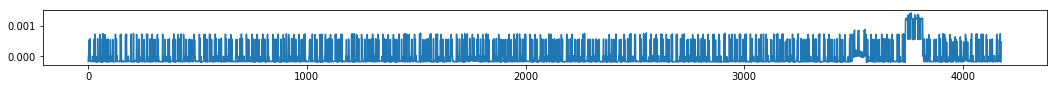

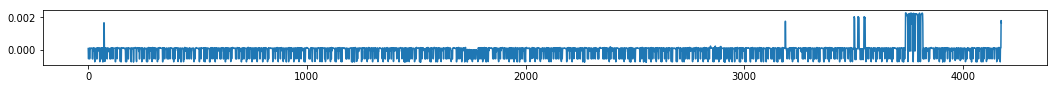

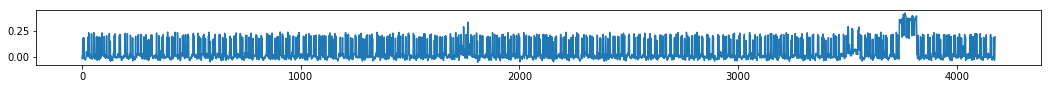

In [353]:
#Test dataset2 and tune the parameters
cand_alpha = [0.5, 0.75, 0.9, 0.99,0.999]
cand_t = [0.5, 1, 2,3,5,10,25, 50]
x =x_2
y = y_2
m = m_2
n = n_2

pca = PCA(n_components=m)
pca.fit(x)
proj_x = pca.transform(x)
norm_x = normalize(proj_x, norm='l1', axis=0)

#Plot the first two principal axes for reference
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,0])
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,1])

(t,a) = tune_params(cand_alpha, cand_t, n, m, x, y)
idx =  seperate_anomalous(norm_x, t,m) 
r= idx-1
prin_comps = pca.components_
P = prin_comps[:,0:r]
C = np.dot(P, P.T)
I = np.identity(m)

x_n = np.dot(C, x.T)
x_a = np.dot(I-C, x.T)
#Plot the redidual part
plt.figure(figsize=(18,1))
plt.plot(x_a[0,:])




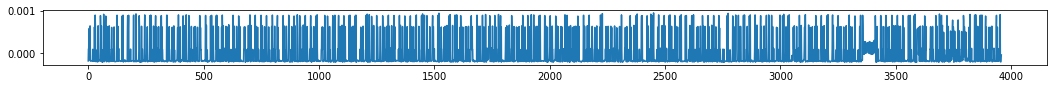

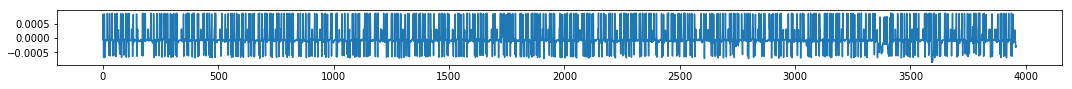

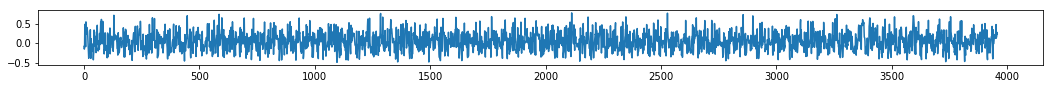

In [355]:
#Test dataset2 with removed abnomalities
clean_x = x_2[y_2==0 ,:]
clean_y = y_2[y_2==0]
x = clean_x
y = clean_y
(n,m) = clean_x.shape

pca = PCA(n_components=m)
pca.fit(x)
proj_x = pca.transform(x)
norm_x = normalize(proj_x, norm='l1', axis=0)

#Plot the first two principal axes for reference
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,0])
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,1])

idx =  seperate_anomalous(norm_x, t,m) 
r= idx-1
prin_comps = pca.components_
P = prin_comps[:,0:r]
C = np.dot(P, P.T)
I = np.identity(m)

x_n = np.dot(C, x.T)
x_a = np.dot(I-C, x.T)
#Plot the redidual part
plt.figure(figsize=(18,1))
plt.plot(x_a[0,:])



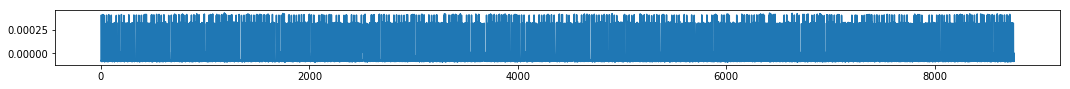

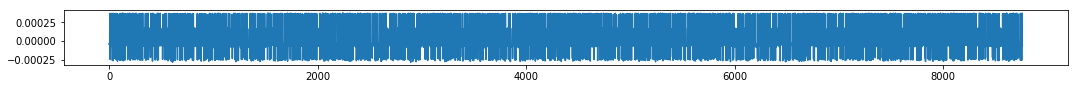

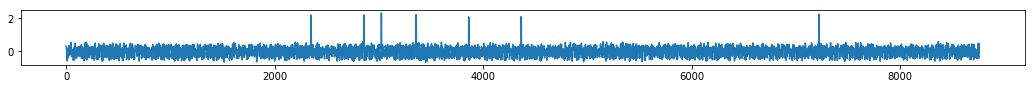

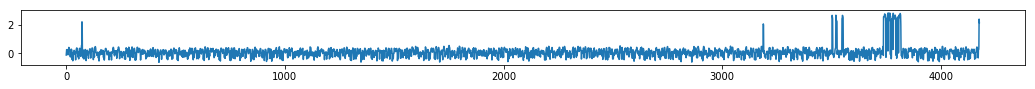

In [358]:
#Test dataset 1
x = x_1
y = y_1
(n,m) = x.shape

pca = PCA(n_components=m)
pca.fit(x)
proj_x = pca.transform(x)
norm_x = normalize(proj_x, norm='l1', axis=0)

plt.figure(figsize=(18,1))
plt.plot(norm_x[:,0])
plt.figure(figsize=(18,1))
plt.plot(norm_x[:,1])

idx =  seperate_anomalous(norm_x, t,m) 
r= idx-1
prin_comps = pca.components_
P = prin_comps[:,0:r]
C = np.dot(P, P.T)
I = np.identity(m)

x_n = np.dot(C, x.T)
x_a = np.dot(I-C, x.T)

plt.figure(figsize=(18,1))
plt.plot(x_a[0,:])

x_2_a = np.dot(I-C, x_2.T)
plt.figure(figsize=(18,1))
plt.plot(x_2_a[0,:])
